Licensed under the MIT License.

Copyright (c) 2021-2031. All rights reserved.

# Try PU Learning

* Process
  1. Predict `P(has_label=1 | sample)`, which is the probability of a record is labeled in the sample
  2. `P(has_label=1 | positive_label=1 | sample)` is the probability of known positive labels in the sample, then get `P(has_label=1 | positive_label=1)`, which is the average of these probabilities
  3. Predict `P(has_label=1 | data)`
  4. `P(positive_label=1 | data) = P(has_label=1 | data) / P(has_label=1 | positive_label=1)`
    * `P(positive_label=1 | data) * P(data) = P(has_label=1 | data) * P(data) / P(has_label=1 | positive_label=1)` ==> `P(positive_label=1 | data) = P(has_label=1 | data) / P(has_label=1 | positive_label=1)`
* Reference: https://towardsdatascience.com/semi-supervised-classification-of-unlabeled-data-pu-learning-81f96e96f7cb

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from category_encoders import TargetEncoder
import lightgbm as lgb
from lightgbm import LGBMClassifier
from matplotlib import pylab as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
def mask_labels_1class_labeled(df, label_col, masked_label, partially_labeled_class=1, mask_rate=0.95):
    df['keep_label'] = False 
    df.loc[df[df[label_col]==partially_labeled_class].sample(frac=1-mask_rate, random_state=10).index, 'keep_label'] = True
    df[masked_label] = df.apply(lambda r: r[label_col] if r['keep_label']==True else -1, axis=1)
    
    return df

In [3]:
label_col = 'deposit'
masked_label = 'masked_deposit'

raw_df = pd.read_pickle('../../crystal_ball/data_collector/structured_data/deposit.pkl')
print(raw_df.shape)
print(raw_df[label_col].value_counts())

raw_df.head()

(11162, 17)
0    5873
1    5289
Name: deposit, dtype: int64


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,1
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,1
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,1
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,1
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,1


In [4]:
# mask the data so that there's only partially positive labeled data
raw_df = mask_labels_1class_labeled(raw_df, label_col, masked_label, partially_labeled_class=1, mask_rate=0.9)
print(raw_df[masked_label].value_counts()*100/raw_df.shape[0])
print()
print(raw_df[raw_df[masked_label]==-1][label_col].value_counts()*100/raw_df[raw_df[masked_label]==-1].shape[0])
raw_df.head()

-1    95.260706
 1     4.739294
Name: masked_deposit, dtype: float64

0    55.233706
1    44.766294
Name: deposit, dtype: float64


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,keep_label,masked_deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,1,False,-1
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,1,False,-1
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,1,False,-1
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,1,False,-1
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,1,True,1


### Train a classifier to predict `P(has_label=1 | sample)`

* The training data is "sample"

In [5]:
cat_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
raw_df[cat_features] = raw_df[cat_features].astype('category')

# generate label "has_label"
raw_df['has_label'] = raw_df['keep_label'].astype(int)

all_y_df = raw_df[[label_col, 'keep_label', masked_label, 'has_label']]
y = raw_df['has_label']
X = raw_df.drop(all_y_df.columns, axis=1)
print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10, stratify=y)
all_y_train = all_y_df.iloc[y_train.index]
all_y_test = all_y_df.iloc[y_test.index]
print(X_train.shape, y_train.shape, all_y_train.shape, X_test.shape, y_test.shape, all_y_test.shape)
print(y_train.value_counts()*100/y_train.shape)
print(y_test.value_counts()*100/y_test.shape)
print()

X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)
all_y_train.reset_index(inplace=True, drop=True)
all_y_test.reset_index(inplace=True, drop=True)

(11162, 16) (11162,)
(8371, 16) (8371,) (8371, 4) (2791, 16) (2791,) (2791, 4)
0    95.257436
1     4.742564
Name: has_label, dtype: float64
0    95.270512
1     4.729488
Name: has_label, dtype: float64



In [6]:
encoder = TargetEncoder(cols=cat_features)
encoded_X_train = encoder.fit_transform(X_train, y_train)
encoded_X_test = encoder.transform(X_test)

encoded_X_train.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,46,0.028736,0.056760,0.042729,0.047908,5,0.037898,0.033575,0.054134,29,0.035433,305,2,-1,0,0.042168
1,48,0.034317,0.041702,0.038053,0.047908,134,0.037898,0.049525,0.020092,28,0.029020,315,2,-1,0,0.042168
2,41,0.034317,0.041702,0.042729,0.047908,4910,0.037898,0.049525,0.054134,3,0.062411,1090,1,-1,0,0.042168
3,29,0.028736,0.056760,0.042729,0.047908,84,0.037898,0.049525,0.054134,13,0.062411,1101,2,-1,0,0.042168
4,39,0.050073,0.041702,0.059636,0.047908,94,0.037898,0.033575,0.020092,16,0.029020,813,1,-1,0,0.042168


In [7]:
params = {'num_leaves': 4, 'learning_rate': 0.01, 'bagging_fraction': 0.8506740422636537, 'feature_fraction': 0.6643670461510903, 
          'bagging_freq': 18, 'min_data_in_leaf': 1133, 'num_iterations': 2956, 'objective': 'binary', 'metric': 'auc', 'random_state': 10, 
          'verbosity': -1, 'boosting': 'gbdt', 'num_threads': 4, 'is_unbalance':True, 'max_bin':250}
opt_model = LGBMClassifier(**params)
opt_model.fit(encoded_X_train, y_train)
y_pred = opt_model.predict(encoded_X_test)
auc = roc_auc_score(y_test, y_pred)
print(f'Testing AUC is {auc}')

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.6643670461510903, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6643670461510903
[LightGBM] [Warning] min_data_in_leaf is set=1133, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1133
[LightGBM] [Warning] bagging_fraction is set=0.8506740422636537, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8506740422636537
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=18, subsample_freq=0 will be ignored. Current value: bagging_freq=18
Testing AUC is 0.654399865522468


### Get `P(has_label=1 | positive_label=1)`

In [8]:
pos_encoded_X_train = encoded_X_train.iloc[all_y_train[all_y_train[masked_label]==1].index]
print(pos_encoded_X_train.shape, pos_encoded_X_train.shape[0]*100/encoded_X_train.shape[0])

(397, 16) 4.742563612471629


In [9]:
pos_has_label_prob = np.mean(opt_model.predict_proba(pos_encoded_X_train)[:, 1])
print(pos_has_label_prob)

0.6368340353734504


### Predict `P(has_label=1 | data)`

* The testing data is "data"

In [10]:
has_label_prob = opt_model.predict_proba(encoded_X_test)[:, 1]
pos_label_prob = has_label_prob/pos_has_label_prob
pos_label_prob

array([0.60210276, 0.72250636, 0.74394194, ..., 0.0748975 , 0.22456186,
       0.77737462])

### Evaluation

#### If all labels are known

In [11]:
auc = roc_auc_score(y_test, pos_label_prob)
print(f'Testing AUC is {auc}')

Testing AUC is 0.6810717175515972


#### Without knowing all labels
* In reality, this is often the case, we can
  * Check the percentage of predicted positive to see whether it aligns with business estimation
  * Evaluate on known lables using recall

In [12]:
threshold = 0.7

In [13]:
def pu_eval(all_y_test, threshold=0.7):
    # predicted positive class percentage
    pred_pos_perct = all_y_test[all_y_test['pred_label']>= threshold].shape[0]/all_y_test.shape[0]

    # recall on known labels
    pos_label_df = all_y_test[all_y_test['masked_deposit']==1]
    tp = pos_label_df[pos_label_df['pred_label']>=threshold].shape[0]
    fn = pos_label_df[pos_label_df['pred_label']<threshold].shape[0]
    known_recall = tp/(tp + fn)
    
    return pred_pos_perct, known_recall

In [14]:
known_pos_perct = all_y_test[all_y_test['masked_deposit']==1].shape[0]/all_y_test.shape[0]
real_pos_perct = all_y_test[all_y_test['deposit']==1].shape[0]/all_y_test.shape[0]  # business estimated percentage should align with this percentage 
print(known_pos_perct, real_pos_perct)
print()

all_y_test['pred_label'] = pos_label_prob
pred_pos_perct, known_recall = pu_eval(all_y_test, threshold=0.7)
print(pred_pos_perct, known_recall)

0.047294876388391256 0.47868147617341456

0.44822644213543533 0.7348484848484849


In [20]:
# plot performance for different theresholds
def plot_performance_per_threshold(threshold_performance_dct, color_dct, title, fig_size=[15, 7]):
    plt.figure(figsize=(fig_size[0], fig_size[1]))
    ax = plt.gca()
    ax.set_ylim([0, 1]) # set y-axis range
    
    x = threshold_performance_dct['threshold_lst']
    
    for performance_name, performance_lst in threshold_performance_dct.items():
        if (performance_name=='threshold_lst'):
            continue
        ax.plot(x, performance_lst, color=color_dct[performance_name], label=performance_name, marker='*')
        
        # annotate y_value along the line
        for i,j in zip(x, performance_lst):
            ax.annotate(str(j),xy=(i,j)) 
    
    plt.xlabel('Positive Label Threshold')
    plt.ylabel('Performance')
    plt.legend(loc='best')
    plt.title(title)
    plt.show()
    
    
def get_plot_dcts(threshold_lst, real_pos_perct):
    threshold_performance_dct = {
        'threshold_lst': threshold_lst,
        'real_pos_perct': [round(real_pos_perct, 2)]*len(threshold_lst),
        'pred_pos_perct': [],
        'known_recall': []
    }
    color_dct = {'real_pos_perct': 'r', 'pred_pos_perct': 'green', 'known_recall': 'purple'}

    for threshold in threshold_lst:
        pred_pos_perct, known_recall = pu_eval(all_y_test, threshold)
        threshold_performance_dct['pred_pos_perct'].append(round(pred_pos_perct, 2))
        threshold_performance_dct['known_recall'].append(round(known_recall, 2))
        
    return threshold_performance_dct, color_dct

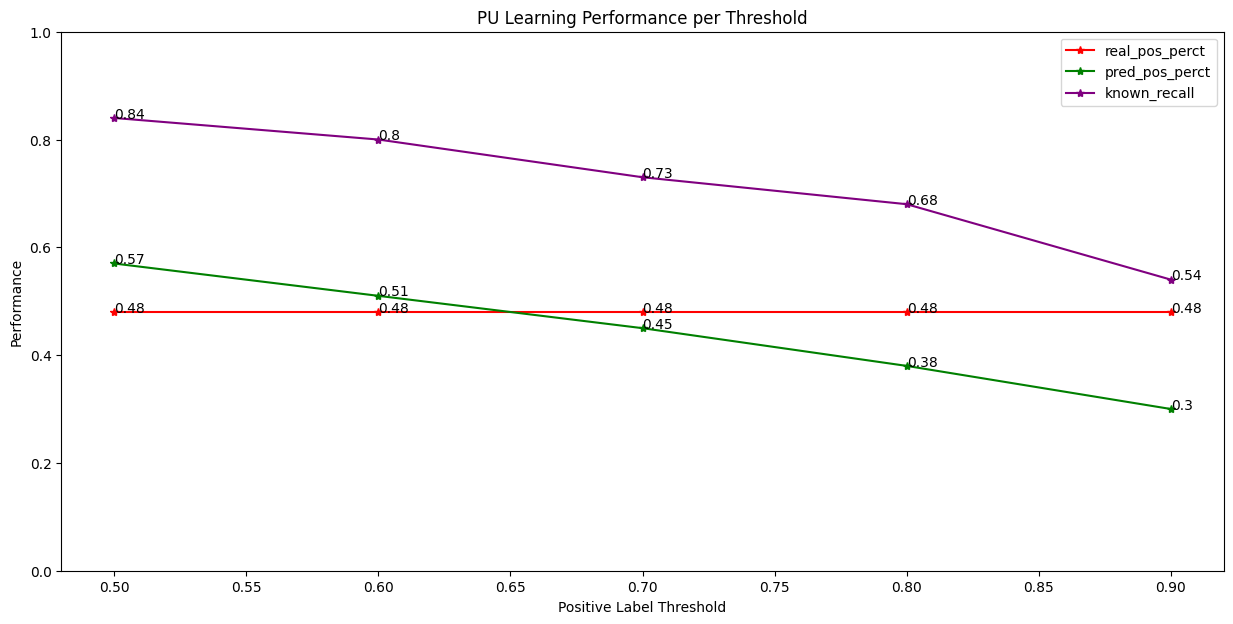

<module 'matplotlib.pylab' from 'C:\\Users\\wuhan\\anaconda3\\envs\\replendent_tree\\lib\\site-packages\\matplotlib\\pylab.py'>

In [21]:
threshold_lst = np.arange(0.5, 1, 0.1)
threshold_performance_dct, color_dct = get_plot_dcts(threshold_lst, real_pos_perct)
    
plot_performance_per_threshold(threshold_performance_dct, color_dct, title='PU Learning Performance per Threshold', fig_size=[15, 7])